In [44]:
!pip install opencage 
!pip install folium
!pip install earthengine-api

import pandas as pd
import numpy as np
from opencage.geocoder import OpenCageGeocode
import time
import folium 
import ee

10877.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


10884.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


10892.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [ ]:
df = pd.read_csv('datafest-data-read-only/Leases.csv')
print(df.columns)


In [ ]:
df['full_address'] = df['address'] + ', ' + df['city'] + ', ' + df['state'] + ' ' + df['zip'].astype(str)


In [ ]:
print(df['full_address'])

In [8]:
df = pd.read_csv('datafest-data-read-only/Leases.csv')

def filter_data(df, year=None, quarter=None, month=None, state=None, city=None, zip_code=None, region=None):
    filtered = df.copy()
    if year is not None:
        if isinstance(year, list):
            filtered = filtered[filtered['year'].isin(year)]
        else:
            filtered = filtered[filtered['year'] == year]

    if quarter is not None:
        if isinstance(quarter, list):
            filtered = filtered[filtered['quarter'].isin(quarter)]
        else:
            filtered = filtered[filtered['quarter'] == quarter]

    if month is not None:
        if isinstance(month, list):
            filtered = filtered[filtered['monthsigned'].isin(month)]
        else:
            filtered = filtered[filtered['monthsigned'] == month]

    if state is not None:
        if isinstance(state, list):
            filtered = filtered[filtered['state'].str.upper().isin([s.upper() for s in state])]
        else:
            filtered = filtered[filtered['state'].str.upper() == state.upper()]

    if city is not None:
        if isinstance(city, list):
            filtered = filtered[filtered['city'].str.lower().isin([c.lower() for c in city])]
        else:
            filtered = filtered[filtered['city'].str.lower() == city.lower()]

    if zip_code is not None:
        if isinstance(zip_code, list):
            filtered = filtered[filtered['zip'].isin(zip_code)]
        else:
            filtered = filtered[filtered['zip'] == int(zip_code)]

    if region is not None:
        if isinstance(region, list):
            filtered = filtered[filtered['region'].str.lower().isin([r.lower() for r in region])]
        else:
            filtered = filtered[filtered['region'].str.lower() == region.lower()]

    return filtered
    

df_filteredData = filter_data(df,2022, quarter=['Q2'], state = 'FL', city='Tampa')
df_filteredData.to_csv('filtered_before.csv', index=False)

df_filteredData = filter_data(df,2022, quarter=['Q4'], state = 'FL', city='Tampa')
df_filteredData.to_csv('filtered_after.csv', index=False)

In [16]:
import pandas as pd
import re

# Define a dictionary to map lowercase full state names to uppercase abbreviations
state_mapping = {
    "alabama": "AL", "alaska": "AK", "arizona": "AZ", "arkansas": "AR", "california": "CA",
    "colorado": "CO", "connecticut": "CT", "delaware": "DE", "florida": "FL", "georgia": "GA",
    "hawaii": "HI", "idaho": "ID", "illinois": "IL", "indiana": "IN", "iowa": "IA",
    "kansas": "KS", "kentucky": "KY", "louisiana": "LA", "maine": "ME", "maryland": "MD",
    "massachusetts": "MA", "michigan": "MI", "minnesota": "MN", "mississippi": "MS",
    "missouri": "MO", "montana": "MT", "nebraska": "NE", "nevada": "NV", "new hampshire": "NH",
    "new jersey": "NJ", "new mexico": "NM", "new york": "NY", "north carolina": "NC",
    "north dakota": "ND", "ohio": "OH", "oklahoma": "OK", "oregon": "OR", "pennsylvania": "PA",
    "rhode island": "RI", "south carolina": "SC", "south dakota": "SD", "tennessee": "TN",
    "texas": "TX", "utah": "UT", "vermont": "VT", "virginia": "VA", "washington": "WA",
    "west virginia": "WV", "wisconsin": "WI", "wyoming": "WY"
}

# Load the lease and disaster data
df = pd.read_csv('datafest-data-read-only/Leases.csv')  # Adjust path as needed
disasters = pd.read_csv('disasters.csv')  # Adjust path as needed

# Helper functions to calculate previous and next quarters
def previous_quarter(year, quarter_str):
    quarter_num = int(quarter_str[1])  # Extract number from 'Q1', 'Q2', etc.
    if quarter_num == 1:
        return year - 1, 'Q4'
    return year, f'Q{quarter_num - 1}'

def next_quarter(year, quarter_str):
    quarter_num = int(quarter_str[1])
    if quarter_num == 4:
        return year + 1, 'Q1'
    return year, f'Q{quarter_num + 1}'

def get_two_previous_quarters(year, quarter_str):
    prev1 = previous_quarter(year, quarter_str)  # One quarter before
    prev2 = previous_quarter(*prev1)             # Two quarters before
    return [prev2, prev1]

def get_two_next_quarters(year, quarter_str):
    next1 = next_quarter(year, quarter_str)  # One quarter after
    next2 = next_quarter(*next1)             # Two quarters after
    return [next1, next2]

# Function to create a slug from the disaster name
def slugify(name):
    return re.sub(r'\W+', '_', name)

# Function to filter lease data based on year, quarter, and state
def filter_data(df, year=None, quarter=None, state=None):
    filtered = df.copy()
    if year is not None:
        filtered = filtered[filtered['year'] == year]
    if quarter is not None:
        filtered = filtered[filtered['quarter'] == quarter]
    if state is not None:
        if isinstance(state, list):
            filtered = filtered[filtered['state'].str.upper().isin([s.upper() for s in state])]
        else:
            filtered = filtered[filtered['state'].str.upper() == state.upper()]
    return filtered

# Initialize aggregate dataframes for before, during, and after
all_disasters_before = pd.DataFrame()
all_disasters_during = pd.DataFrame()
all_disasters_after = pd.DataFrame()

# Process each disaster
for i, row in disasters.iterrows():
    disaster_year = row['Year']
    disaster_quarter = row['Quarter']
    disaster_name = row['Disaster']
    estimated_damages = row['Estimated Damages']
    
    # Convert full state names to abbreviations
    states_full = [state.strip().lower() for state in row['States Affected'].split(', ')]
    states_abbr = [state_mapping.get(state) for state in states_full if state in state_mapping]
    
    # Calculate quarters for before, during, and after
    before_quarters = get_two_previous_quarters(disaster_year, disaster_quarter)  # Two quarters before
    during_quarter = [(disaster_year, disaster_quarter)]                         # Disaster quarter
    after_quarters = get_two_next_quarters(disaster_year, disaster_quarter)      # Two quarters after
    
    # Filter lease data for each period
    filtered_before = pd.concat([
        filter_data(df, year=y, quarter=q, state=states_abbr) for y, q in before_quarters
    ])
    filtered_during = pd.concat([
        filter_data(df, year=y, quarter=q, state=states_abbr) for y, q in during_quarter
    ])
    filtered_after = pd.concat([
        filter_data(df, year=y, quarter=q, state=states_abbr) for y, q in after_quarters
    ])
    
    # Add disaster details to the filtered data
    filtered_before = filtered_before.assign(disaster=disaster_name, estimated_damages=estimated_damages)
    filtered_during = filtered_during.assign(disaster=disaster_name, estimated_damages=estimated_damages)
    filtered_after = filtered_after.assign(disaster=disaster_name, estimated_damages=estimated_damages)
    
    # Generate slug for filenames
    slug = slugify(disaster_name)
    
    # Save individual files for each period
    filtered_before.to_csv(f"{slug}_before.csv", index=False)
    filtered_during.to_csv(f"{slug}_during.csv", index=False)
    filtered_after.to_csv(f"{slug}_after.csv", index=False)
    
    # Concatenate to aggregate dataframes
    all_disasters_before = pd.concat([all_disasters_before, filtered_before], ignore_index=True)
    all_disasters_during = pd.concat([all_disasters_during, filtered_during], ignore_index=True)
    all_disasters_after = pd.concat([all_disasters_after, filtered_after], ignore_index=True)

# Save aggregate files
all_disasters_before.to_csv("all_disasters_before.csv", index=False)
all_disasters_during.to_csv("all_disasters_during.csv", index=False)
all_disasters_after.to_csv("all_disasters_after.csv", index=False)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 32


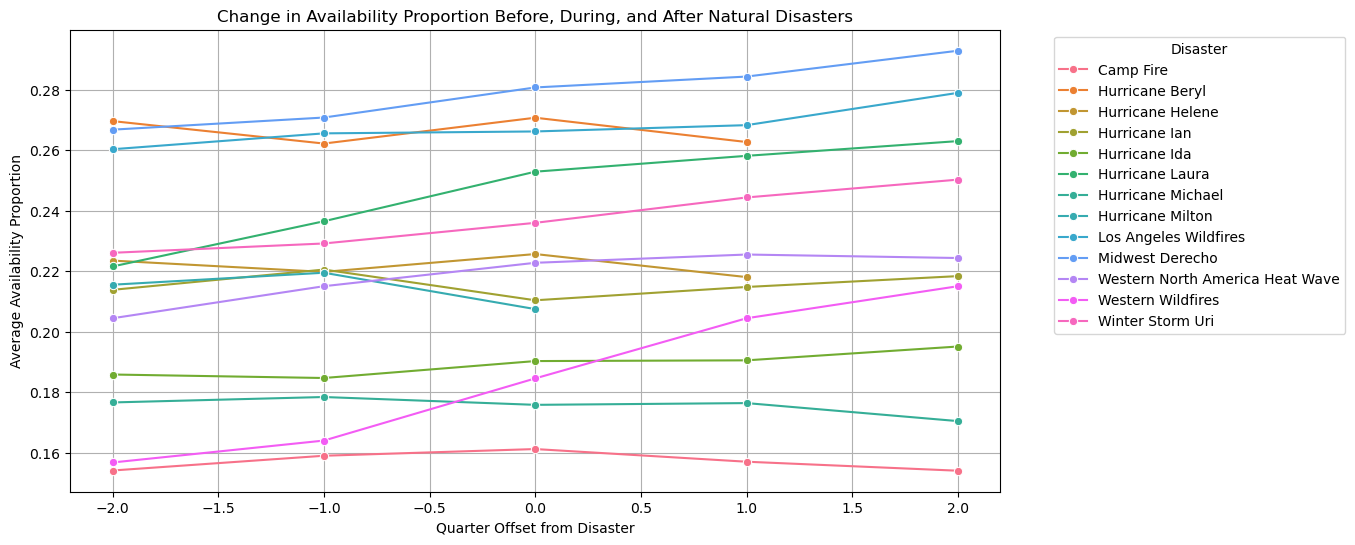

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the data from CSV files
df_before = pd.read_csv('all_disasters_before.csv')
df_during = pd.read_csv('all_disasters_during.csv')
df_after = pd.read_csv('all_disasters_after.csv')

# Step 2: Concatenate into one DataFrame
df_all = pd.concat([df_before, df_during, df_after], ignore_index=True)

# Step 3: Load disasters data and create a dictionary for disaster year and quarter
disasters = pd.read_csv('disasters.csv')
disaster_info = disasters.set_index('Disaster')[['Year', 'Quarter']].to_dict(orient='index')

# Step 4: Define a function to calculate the quarter index
def quarter_index(year, quarter):
    # Extract quarter number (1, 2, 3, or 4) from 'Q1', 'Q2', etc.
    q_num = int(quarter[1])
    return year * 4 + (q_num - 1)

# Step 5: Define a function to calculate quarter offset for each row
def calculate_offset(row):
    disaster = row['disaster']
    if disaster in disaster_info:
        d_year, d_quarter = disaster_info[disaster]['Year'], disaster_info[disaster]['Quarter']
        d_index = quarter_index(d_year, d_quarter)
        row_index = quarter_index(row['year'], row['quarter'])
        return row_index - d_index
    return None

# Step 6: Apply the function to add 'quarter_offset' column
df_all['quarter_offset'] = df_all.apply(calculate_offset, axis=1)

# Step 7: Group by 'disaster' and 'quarter_offset', calculate mean 'availability_proportion'
grouped = df_all.groupby(['disaster', 'quarter_offset'])['availability_proportion'].mean().reset_index()

# Step 8: Create the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped,
    x='quarter_offset',
    y='availability_proportion',
    hue='disaster',
    marker='o'  # Add markers at data points
)
plt.xlabel('Quarter Offset from Disaster')
plt.ylabel('Average Availability Proportion')
plt.title('Change in Availability Proportion Before, During, and After Natural Disasters')
plt.legend(title='Disaster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside plot
plt.grid(True)  # Add a grid for readability
plt.show()

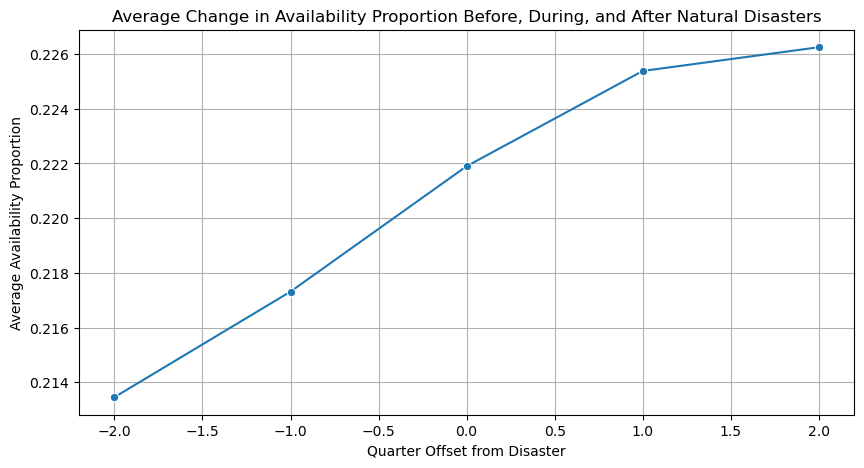

In [21]:
# Import necessary libraries (if not already imported)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the average availability proportion across all disasters for each quarter offset
average_grouped = grouped.groupby('quarter_offset')['availability_proportion'].mean().reset_index()

# Step 2: Create the averaged line graph
plt.figure(figsize=(10, 5))  # Set figure size
sns.lineplot(
    data=average_grouped,
    x='quarter_offset',
    y='availability_proportion',
    marker='o'  # Add markers to highlight data points
)

# Add labels and title
plt.xlabel('Quarter Offset from Disaster')
plt.ylabel('Average Availability Proportion')
plt.title('Average Change in Availability Proportion Before, During, and After Natural Disasters')

# Add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()

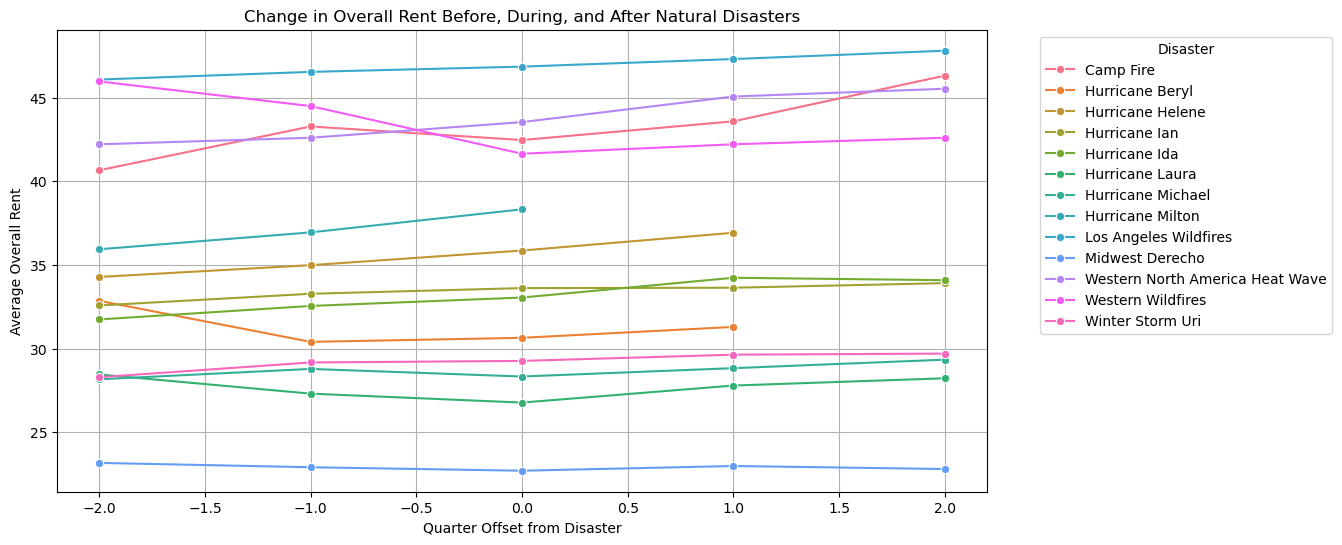

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the data from CSV files
df_before = pd.read_csv('all_disasters_before.csv')
df_during = pd.read_csv('all_disasters_during.csv')
df_after = pd.read_csv('all_disasters_after.csv')

# Step 2: Concatenate into one DataFrame
df_all = pd.concat([df_before, df_during, df_after], ignore_index=True)

# Step 3: Load disasters data and create a dictionary for disaster year and quarter
disasters = pd.read_csv('disasters.csv')
disaster_info = disasters.set_index('Disaster')[['Year', 'Quarter']].to_dict(orient='index')

# Step 4: Define a function to calculate the quarter index
def quarter_index(year, quarter):
    # Extract quarter number (1, 2, 3, or 4) from 'Q1', 'Q2', etc.
    q_num = int(quarter[1])
    return year * 4 + (q_num - 1)

# Step 5: Define a function to calculate quarter offset for each row
def calculate_offset(row):
    disaster = row['disaster']
    if disaster in disaster_info:
        d_year, d_quarter = disaster_info[disaster]['Year'], disaster_info[disaster]['Quarter']
        d_index = quarter_index(d_year, d_quarter)
        row_index = quarter_index(row['year'], row['quarter'])
        return row_index - d_index
    return None

# Step 6: Apply the function to add 'quarter_offset' column
df_all['quarter_offset'] = df_all.apply(calculate_offset, axis=1)

# Step 7: Group by 'disaster' and 'quarter_offset', calculate mean 'availability_proportion'
grouped = df_all.groupby(['disaster', 'quarter_offset'])['internal_class_rent'].mean().reset_index()

# Step 8: Create the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped,
    x='quarter_offset',
    y='internal_class_rent',
    hue='disaster',
    marker='o'  # Add markers at data points
)
plt.xlabel('Quarter Offset from Disaster')
plt.ylabel('Average Overall Rent')
plt.title('Change in Overall Rent Before, During, and After Natural Disasters')
plt.legend(title='Disaster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside plot
plt.grid(True)  # Add a grid for readability
plt.show()

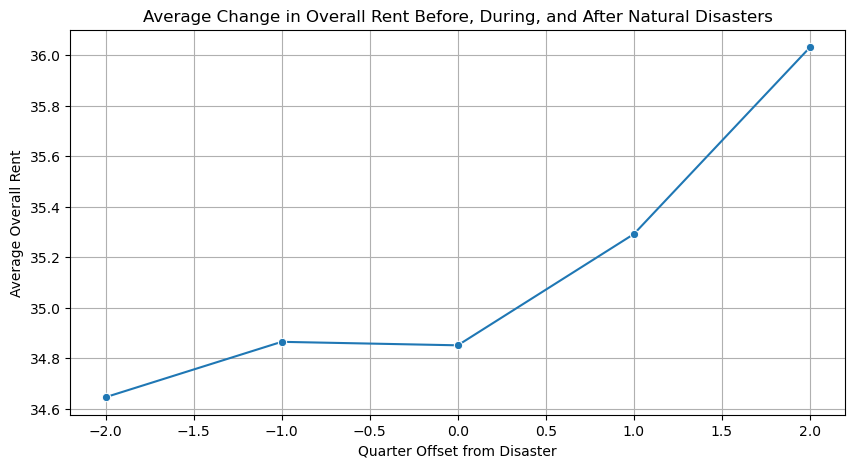

In [8]:
# Import necessary libraries (if not already imported)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the average availability proportion across all disasters for each quarter offset
average_grouped = grouped.groupby('quarter_offset')['internal_class_rent'].mean().reset_index()

# Step 2: Create the averaged line graph
plt.figure(figsize=(10, 5))  # Set figure size
sns.lineplot(
    data=average_grouped,
    x='quarter_offset',
    y='internal_class_rent',
    marker='o'  # Add markers to highlight data points
)

# Add labels and title
plt.xlabel('Quarter Offset from Disaster')
plt.ylabel('Average Overall Rent')
plt.title('Average Change in Overall Rent Before, During, and After Natural Disasters')

# Add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()

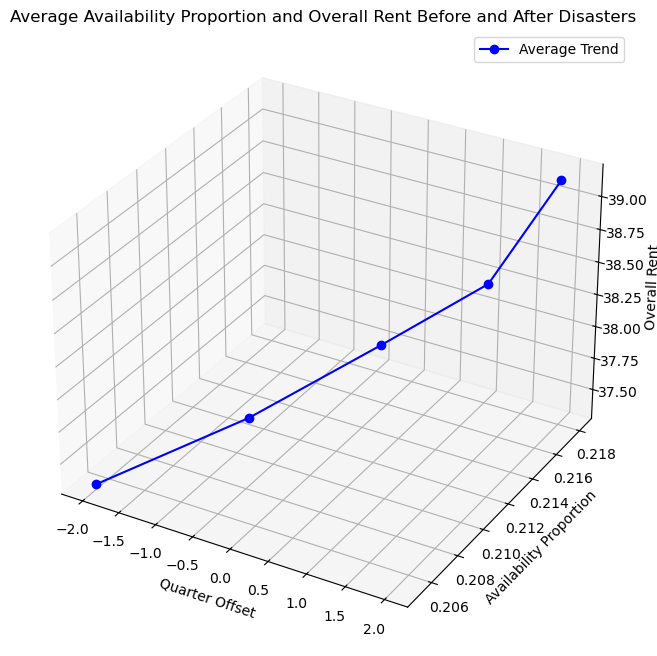

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Load the data
df_before = pd.read_csv('all_disasters_before.csv')
df_during = pd.read_csv('all_disasters_during.csv')
df_after = pd.read_csv('all_disasters_after.csv')
df_all = pd.concat([df_before, df_during, df_after], ignore_index=True)

# Step 2: Load disaster information
disasters = pd.read_csv('disasters.csv')
disaster_info = disasters.set_index('Disaster')[['Year', 'Quarter']].to_dict(orient='index')

# Step 3: Define function to calculate quarter index
def quarter_index(year, quarter):
    q_num = int(quarter[1])  # Extract quarter number (e.g., 'Q1' -> 1)
    return year * 4 + (q_num - 1)

# Step 4: Define function to calculate quarter offset
def calculate_offset(row):
    disaster = row['disaster']
    if disaster in disaster_info:
        d_year, d_quarter = disaster_info[disaster]['Year'], disaster_info[disaster]['Quarter']
        d_index = quarter_index(d_year, d_quarter)
        row_index = quarter_index(row['year'], row['quarter'])
        return row_index - d_index
    return None

# Step 5: Apply quarter offset to the data
df_all['quarter_offset'] = df_all.apply(calculate_offset, axis=1)

# Step 6: Group by quarter_offset and calculate means
average_grouped = df_all.groupby('quarter_offset').agg({
    'availability_proportion': 'mean',
    'overall_rent': 'mean'
}).reset_index()

# Step 7: Sort by quarter_offset for proper line connection
average_grouped = average_grouped.sort_values('quarter_offset')

# Step 8: Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot line with points
ax.plot(
    average_grouped['quarter_offset'],
    average_grouped['availability_proportion'],
    average_grouped['overall_rent'],
    marker='o',  # Add points at each data point
    color='blue',  # Line and point color
    label='Average Trend'
)

# Step 9: Set labels and title
ax.set_xlabel('Quarter Offset')
ax.set_ylabel('Availability Proportion')
ax.set_zlabel('Overall Rent')
ax.set_title('Average Availability Proportion and Overall Rent Before and After Disasters')

# Add a legend
ax.legend()

# Step 10: Display the plot
plt.show()

In [25]:
import pandas as pd

# Load the data from the provided file
# Replace 'your_file_path.txt' with the actual file path
data = pd.read_csv('Economics.csv')

# Step 1: Identify columns with year:quarter format and regular columns
year_quarter_cols = [col for col in data.columns if ':' in str(col)]
regular_cols = ['State', 'Description']

# Step 2: Create a new dataframe in long format
long_data = pd.melt(
    data,
    id_vars=regular_cols,
    value_vars=year_quarter_cols,
    var_name='Year_Quarter',
    value_name='Value'
)

# Step 3: Split the Year_Quarter column into separate Year and Quarter columns
long_data[['Year', 'Quarter']] = long_data['Year_Quarter'].str.split(':', expand=True)
long_data = long_data.drop('Year_Quarter', axis=1)

# Step 4: Create simplified description names
def get_description_type(desc):
    if 'Real GDP (millions of chained 2017 dollars)' in desc:
        return 'Real_GDP'
    elif 'Chain-type quantity indexes for real GDP' in desc:
        return 'GDP_Index'
    elif 'Current-dollar GDP (millions of current dollars)' in desc:
        return 'Current_Dollar_GDP'
    else:
        return 'Other'

long_data['Type'] = long_data['Description'].apply(get_description_type)

# Step 5: Pivot the data to have separate columns for each description type
final_data = long_data.pivot_table(
    index=['State', 'Year', 'Quarter'],
    columns='Type',
    values='Value',
    aggfunc='first'
).reset_index()

# Step 6: Clean up and format
final_data.columns.name = None  # Remove the columns' name
final_data['Year'] = final_data['Year'].astype(int)

# Display the final result
print(final_data.head())


final_data.to_csv("Economics_filtered.csv", index=False)


     State  Year Quarter  Current_Dollar_GDP  GDP_Index  Real_GDP
0  Alabama  2018      Q1            223670.1    101.591  220062.1
1  Alabama  2018      Q2            225398.8    101.642  220171.5
2  Alabama  2018      Q3            226627.4    101.825  220569.5
3  Alabama  2018      Q4            229358.8    102.685  222432.0
4  Alabama  2019      Q1            231258.9    102.961  223030.4


In [31]:
df1 = pd.read_csv('Economics_filtered.csv')
df2 = pd.read_csv('all_disasters_after.csv')

state_abbreviation_map = {
'Alabama': 'AL',
'Alaska': 'AK',
'Arizona': 'AZ',
'Arkansas': 'AR',
'California': 'CA',
'Colorado': 'CO',
'Connecticut': 'CT',
'Delaware': 'DE',
'Florida': 'FL',
'Georgia': 'GA',
'Hawaii': 'HI',
'Idaho': 'ID',
'Illinois': 'IL',
'Indiana': 'IN',
'Iowa': 'IA',
'Kansas': 'KS',
'Kentucky': 'KY',
'Louisiana': 'LA',
'Maine': 'ME',
'Maryland': 'MD',
'Massachusetts': 'MA',
'Michigan': 'MI',
'Minnesota': 'MN',
'Mississippi': 'MS',
'Missouri': 'MO',
'Montana': 'MT',
'Nebraska': 'NE',
'Nevada': 'NV',
'New Hampshire': 'NH',
'New Jersey': 'NJ',
'New Mexico': 'NM',
'New York': 'NY',
'North Carolina': 'NC',
'North Dakota': 'ND',
'Ohio': 'OH',
'Oklahoma': 'OK',
'Oregon': 'OR',
'Pennsylvania': 'PA',
'Rhode Island': 'RI',
'South Carolina': 'SC',
'South Dakota': 'SD',
'Tennessee': 'TN',
'Texas': 'TX',
'Utah': 'UT',
'Vermont': 'VT',
'Virginia': 'VA',
'Washington': 'WA',
'West Virginia': 'WV',
'Wisconsin': 'WI',
'Wyoming': 'WY'
}

# Map full state names in Dataset 1 to their abbreviations
df1['state'] = df1['State'].map(state_abbreviation_map)

# Rename columns in Dataset 2 to match Dataset 1 for merging
df2.rename(columns={'year': 'Year', 'quarter': 'Quarter'}, inplace=True)

# Merge the two dataframes on 'state', 'Year', and 'Quarter'
df_combined = pd.merge(df1, df2, on=['state', 'Year', 'Quarter'], how='inner')

print(df_combined)

df_combined.to_csv("econs_after.csv", index=False)

            State  Year Quarter  Current_Dollar_GDP  GDP_Index   Real_GDP  \
0      California  2019      Q1           2987644.2    106.177  2909833.5   
1      California  2019      Q1           2987644.2    106.177  2909833.5   
2      California  2019      Q1           2987644.2    106.177  2909833.5   
3      California  2019      Q1           2987644.2    106.177  2909833.5   
4      California  2019      Q1           2987644.2    106.177  2909833.5   
...           ...   ...     ...                 ...        ...        ...   
26088  Washington  2021      Q4            711796.8    121.443   640212.4   
26089  Washington  2021      Q4            711796.8    121.443   640212.4   
26090  Washington  2021      Q4            711796.8    121.443   640212.4   
26091  Washington  2021      Q4            711796.8    121.443   640212.4   
26092  Washington  2021      Q4            711796.8    121.443   640212.4   

      state  monthsigned       market              building_name  ...  \
0 

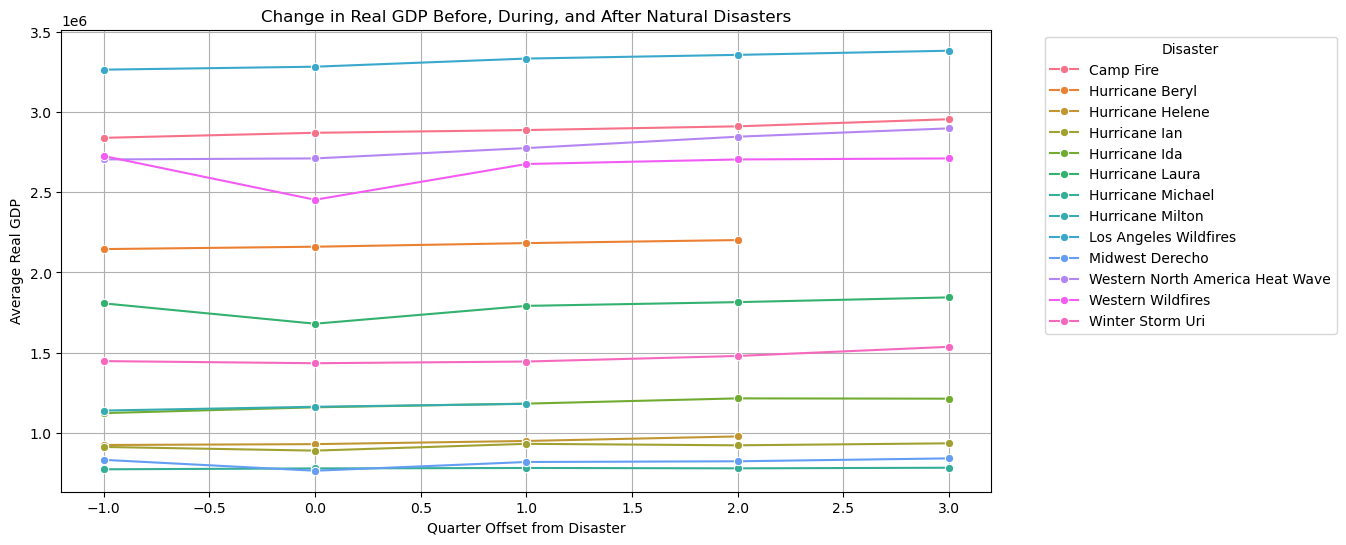

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the data from CSV files
df_before = pd.read_csv('econs_before.csv')
df_during = pd.read_csv('econs_during.csv')
df_after = pd.read_csv('econs_after.csv')

# Step 2: Concatenate into one DataFrame
df_all = pd.concat([df_before, df_during, df_after], ignore_index=True)

# Step 3: Load disasters data and create a dictionary for disaster year and quarter
disasters = pd.read_csv('disasters.csv')
disaster_info = disasters.set_index('Disaster')[['Year', 'Quarter']].to_dict(orient='index')

# Step 4: Define a function to calculate the quarter index
def quarter_index(year, quarter):
    # Extract quarter number (1, 2, 3, or 4) from 'Q1', 'Q2', etc.
    q_num = int(quarter[1])
    return year * 4 + (q_num - 1)

# Step 5: Define a function to calculate quarter offset for each row
# Step 5: Define the modified function to calculate quarter offset
def calculate_offset_modified(row):
    disaster = row['disaster']
    if disaster in disaster_info:
        d_year, d_quarter = disaster_info[disaster]['Year'], disaster_info[disaster]['Quarter']
        # Adjust onset date to Q:-1 by subtracting 1 from the disaster index
        d_index = quarter_index(d_year, d_quarter) - 1
        row_index = quarter_index(row['Year'], row['Quarter'])
        return row_index - d_index
    return None

# Step 6: Apply the modified function to add 'quarter_offset' column
df_all['quarter_offset'] = df_all.apply(calculate_offset_modified, axis=1)

# Step 7: Group by 'disaster' and 'quarter_offset', calculate mean 'Real_GDP'
grouped = df_all.groupby(['disaster', 'quarter_offset'])['Real_GDP'].mean().reset_index()

# Step 8: Create the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped,
    x='quarter_offset',
    y='Real_GDP',
    hue='disaster',
    marker='o'  # Add markers at data points
)
plt.xlabel('Quarter Offset from Disaster')
plt.ylabel('Average Real GDP')
plt.title('Change in Real GDP Before, During, and After Natural Disasters')
plt.legend(title='Disaster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside plot
plt.grid(True)  # Add a grid for readability
plt.show()

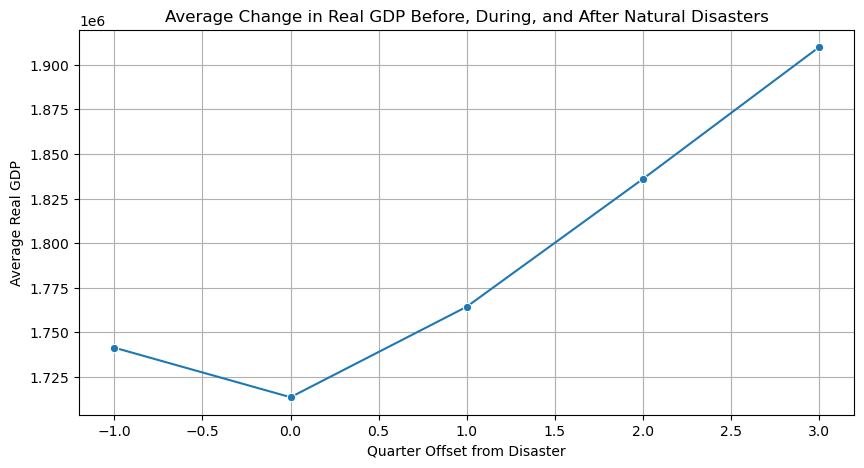

In [49]:
# Import necessary libraries (if not already imported)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the average availability proportion across all disasters for each quarter offset
average_grouped = grouped.groupby('quarter_offset')['Real_GDP'].mean().reset_index()

# Step 2: Create the averaged line graph
plt.figure(figsize=(10, 5))  # Set figure size
sns.lineplot(
    data=average_grouped,
    x='quarter_offset',
    y='Real_GDP',
    marker='o'  # Add markers to highlight data points
)

# Add labels and title
plt.xlabel('Quarter Offset from Disaster')
plt.ylabel('Average Real GDP')
plt.title('Average Change in Real GDP Before, During, and After Natural Disasters')

# Add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()